# Exploring Dataset

In [1]:
import pandas as pd

path2csv = "./data/cancer/train_labels.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [2]:
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


<AxesSubplot:>

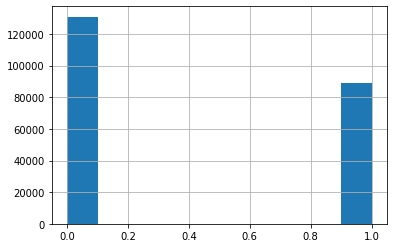

In [3]:
%matplotlib inline
labels_df['label'].hist()

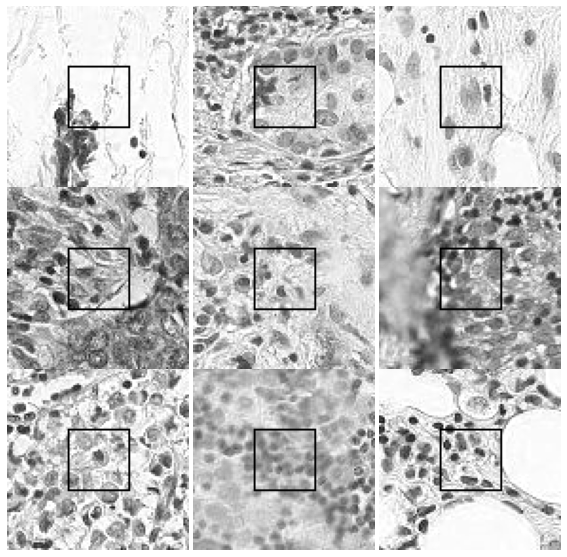

In [4]:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

#  data is stored here
path2train = "./data/cancer/train/"

# show images in grayscale, if you want color change it to True
color = False

#  set figure size
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3

# display images
for i, id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train, id_+'.tif')
    #load image
    img = Image.open(full_filenames)
    
    # draw a 32 * 32 rect
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32,32), (64,64)), outline="green")
    plt.subplot(nrows, ncols, i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap="gray")
    plt.axis('off')

In [5]:
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


# Custom Dataset

In [6]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # path to images
        path2data = os.path.join(data_dir, data_type)
        
        # get a list of images
        filenames = os.listdir(path2data)
        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename = data_type+"_labels.csv"
        path2csvLabels = os.path.join(data_dir, csv_filename)
        labels_df = pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
#            return size of dataset
        return len(self.full_filenames)

        
    def __getitem__(self, idx):
#             open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])# PIL image
        image = self.transform(image)
        return image, self.labels[idx]

/home/haniflinux/coding-coding/magang/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torchvision.transforms as transforms

data_transformer = transforms.Compose([transforms.ToTensor()])

data_dir = "./data/cancer"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [8]:
# load an image
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


# Splitting Dataset

In [9]:
from torch.utils.data import random_split

len_histo = len(histo_dataset)
len_train = int(0.8*len_histo)
len_val = len_histo - len_train

train_ds, val_ds = random_split(histo_dataset, [len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [10]:
for x,y in train_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 0


In [11]:
for x,y in val_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 0


In [12]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

def show(img, y, color=False):
    # convert to tensor to numpy array
    npimg = img.numpy()
    # convert to H*W*C shape
    npimg_tr = np.transpose(npimg,(1,2,0))
    if color==False:
        npimg = npimg_tr[:,:,0]
        plt.imshow(npimg_tr, interpolation='nearest',cmap='gray')
    else:
        # display images
        plt.imshow(npimg_tr, interpolation="nearest")
    plt.title("label: "+str(y))

In [13]:
grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds),grid_size)
print("image indices:", rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow = 4, padding=2)
print(x_grid_train.shape)

image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


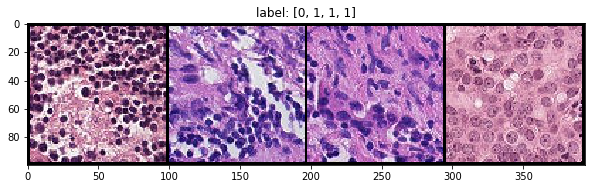

In [14]:
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train, y_grid_train)

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


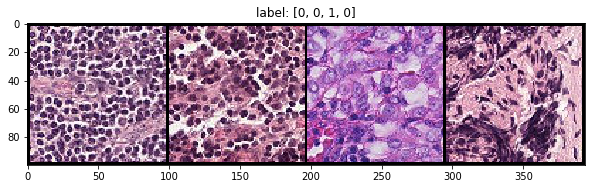

In [15]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val = [val_ds[i][0] for i in range(grid_size)]
y_grid_val = [val_ds[i][1] for i in range(grid_size)]

x_grid_val = utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val, y_grid_val)

# Transforming data

In [16]:
train_trainsformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(96, scale=(0.8,1.0), ratio=(1.0,1.0)),
    transforms.ToTensor()
])

val_transformer = transforms.Compose([transforms.ToTensor()]) # ngejalanin perintah transformasi, secara terurut. dia ngebuat object kalo sekali jalan ngebuat 3 transformasi itu


# overwrite the transform functions
train_ds.transform = train_trainsformer
val_ds.transform = val_transformer

# Creating dataloaders

In [17]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

In [18]:
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break
torch.Size([32, 3, 96, 96])
torch.Size([32])

torch.Size([32, 3, 96, 96])
torch.Size([32])


torch.Size([32])

In [19]:
for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


# Building the classification model

In [20]:
# get labels for validation dataset
y_val = [y for _,y in val_ds]

In [21]:
def accuracy(labels,out):
    return np.sum(out==labels)/float(len(labels))

In [22]:
# accuracy all zero predictions
acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)

accuracy all zero prediction: 0.59


In [23]:
acc_all_ones = accuracy(y_val,np.ones_like(y_val))

print("accuracy all one prediction: %.2f" %acc_all_ones)

accuracy all one prediction: 0.41


In [24]:
acc_random = accuracy(y_val, np.random.randint(2,size=len(y_val)))

print("accuracy random prediction: %.2f" %acc_random)

accuracy random prediction: 0.50


### output size

In [25]:
import torch.nn as nn
import numpy as np

def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    
    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out = np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out), int(W_out)
        

In [26]:
# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w = findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [27]:
# Implement CNN model
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w = findConv2dOutShape(H_in,W_in,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h,w, self.conv4)
        # compute the flatten size
        self.num_flatten = h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [28]:
##### dict to define model parameters
params_model={
    "input_shape":(3,96,96),
    "initial_filters": 8,
    "num_fc1":100,
    "dropout_rate": 0.24,
    "num_classes": 2,
}

# create model
cnn_model = Net(params_model)

In [29]:
# Move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model = cnn_model.to(device)

In [30]:
print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [31]:
print(next(cnn_model.parameters()).device)

cuda:0


In [32]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


# Defining the loss function

In [33]:
loss_func = nn.NLLLoss(reduction="sum")

In [34]:
torch.manual_seed(0)

n,c = 8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out = ls_F(y)
print(y_out.shape)

target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [35]:
loss.backward()
print(y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


# Defining the optimizer

In [36]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

In [37]:
# get learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [38]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

In [39]:
for i in range(100):
    lr_scheduler.step(1)

Epoch 00022: reducing learning rate of group 0 to 1.5000e-04.
Epoch 00043: reducing learning rate of group 0 to 7.5000e-05.
Epoch 00064: reducing learning rate of group 0 to 3.7500e-05.
Epoch 00085: reducing learning rate of group 0 to 1.8750e-05.


# Training and evaluation of the model

In [40]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [41]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [42]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        # move batch to device
        xb = xb.to(device)
        yb = yb.to(device)
        # get model output
        output = model(xb)
        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
    
        # update running loss
        running_loss+=loss_b
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b
        
        # break the loop in case of sanity check
        if sanity_check is True:
            break
            
    # average loss value
    loss = running_loss/float(len_data)
    # average metric value
    metric = running_metric/float(len_data)
    return loss, metric

In [71]:
def train_val(model, params):
    # extract model parameters
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    # history of loss values in each epoch
    loss_history = {
        "train":[],
        "val":[],
    }
    # history of metric values epoch
    metric_history = {
        "train":[],
        "val":[],
    }
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss = float('inf')
    # main loop
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
        # train model on training dataset
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func, train_dl,sanity_check,opt)
        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

            # store best model
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                # store weights into a local file
                torch.save(model.state_dict(), path2weights)
                print("Copied best model weights!")
            # collect loss and metric for validation dataset
            loss_history["val"].append(val_loss)
            metric_history["val"].append(val_metric)
            # learning rate schedule
            lr_scheduler.step(val_loss)
            if current_lr != get_lr(opt):
                print("Loading best model weights!")
                model.load_state_dict(best_model_wts)
            print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
            print("-"*10)
        # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [72]:
import copy
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

In [78]:
params_train={
 "num_epochs": 100,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": True,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./models/weights.pt",
}
# train and validate the model
cnn_mode, loss_hist, metric_hist = train_val(cnn_model, params_train)

Epoch 0/99, current lr=1.875e-05
Copied best model weights!
train loss: 0.000068, dev loss: 0.000698, accuracy: 0.11
----------
Epoch 1/99, current lr=1.875e-05
train loss: 0.000074, dev loss: 0.000698, accuracy: 0.11
----------
Epoch 2/99, current lr=1.875e-05
Copied best model weights!
train loss: 0.000097, dev loss: 0.000698, accuracy: 0.11
----------
Epoch 3/99, current lr=1.875e-05
train loss: 0.000074, dev loss: 0.000698, accuracy: 0.11
----------
Epoch 4/99, current lr=1.875e-05
Copied best model weights!
train loss: 0.000061, dev loss: 0.000697, accuracy: 0.11
----------
Epoch 5/99, current lr=1.875e-05
Copied best model weights!
train loss: 0.000095, dev loss: 0.000695, accuracy: 0.11
----------
Epoch 6/99, current lr=1.875e-05
Copied best model weights!
train loss: 0.000073, dev loss: 0.000694, accuracy: 0.11
----------
Epoch 7/99, current lr=1.875e-05
Copied best model weights!
train loss: 0.000076, dev loss: 0.000692, accuracy: 0.11
----------
Epoch 8/99, current lr=1.875e-

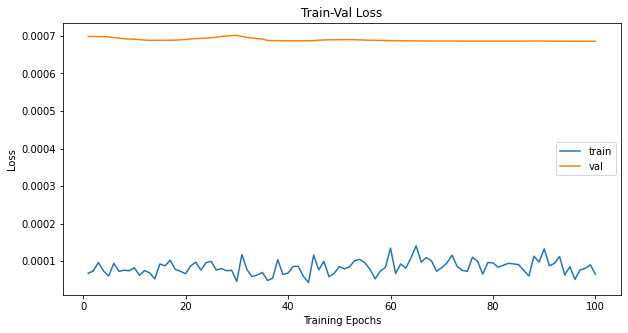

In [79]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

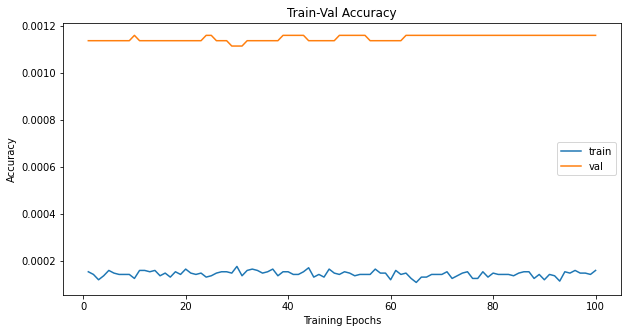

In [80]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()